In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import scipy
from scipy import signal

%matplotlib inline

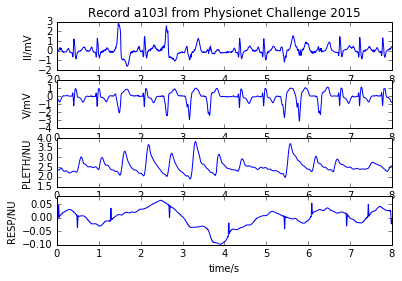

In [17]:
# SQI algorithm

# load data
# Read the wfdb file, plot the last part of the signals
sig, fields=wfdb.rdsamp('sample_data/challenge_training_data/v532s')
wfdb.plotwfdb(sig[292*250:,:], fields, title='Record a103l from Physionet Challenge 2015') 

In [18]:
# find ECGs
ecg_names = ['ECG','EKG',
             'I','II','III','AVR','AVL',
             'AVF','V','V1','V2','V3','V4',
             'V5','V6','MCL1','MCL2','MCL3',
             'MCL4','MCL5','MCL6','aVR','aVL','aVF']
ecg_names = [x.lower() for x in ecg_names]
signame = fields['signame']
idxECG = np.where([x.lower() in ecg_names for x in signame])[0]
idxECG

array([0, 1])

In [19]:
# peak detect ECGs
peaks = [list() for m in range(sig.shape[1])]

# parameters - all times in seconds
integrator_window_size=11
refractory=0.250
thresh=0.5
fs=250
N_medfilt = int(np.ceil(0.1*fs))
batch_size=0 # TODO: implement batching of signal
N = sig.shape[0]

# filter used for bandpass
filter_type='ricker' # one of 'ricker','hamming'


if filter_type == 'ricker':
    bpf = 2.0*signal.ricker(41, 4.0)
# apply band-pass filter without scaling the signal

for m in idxECG:
    sig[:,m] = signal.filtfilt(bpf,1,sig[:,m])
    
    sig[0,m] = sig[1,m] - sig[0,m]
    sig[1:,m] = sig[1:,m] - sig[:-1,m]
    sig[:,m] = sig[:,m]**2
    sig[:,m] = signal.filtfilt(np.ones(integrator_window_size),1,sig[:,m])
    sig[:,m] = signal.medfilt(sig[:,m],kernel_size=N_medfilt)
    
    #? adaptive threshold?
    
    # if the signal < 20 seconds, use the 98th percentile
    if N/fs < 20:
        th = np.percentile(sig[:,m],98)
    else:
        # median of the 98th percentile in 5 segments of the signal
        th = [np.percentile( sig[np.floor(n*(N/5)):np.floor((n+1)*(N/5)),m], 98 )
             for n in range(5)]
        th = np.median(th)
        
    
    peaks[m] = sig[:,m] > (th*thresh)
    
    # TODO:search back
    

# find ABP

# peak detect ABP

# find PPG

# peak detect PPG

/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[ 0.148  0.152  0.156  0.16   0.164  0.168  0.172  0.176  0.18   0.184
  0.188  0.192  0.196  0.2    0.204  0.208  0.212  0.216  0.22   0.224
  0.228  0.72   0.724  0.728  0.732  0.736  0.74   0.744  0.748  0.752
  0.756  0.76   0.764  0.768  0.772  0.776  0.78   0.784  0.788  0.792
  0.796  0.8    2.4    2.404  2.408  2.412  2.416  2.42   2.424  2.428
  2.432  2.436  2.44   2.444  2.448  2.452  2.456  2.46   2.464  2.468
  2.472  2.476  2.48   2.484  3.544  3.548  3.552  3.556  3.56   3.564
  3.568  3.572  3.576  3.58   3.584  3.588  3.592  3.596  3.6    3.604
  3.608  3.612  3.616  3.62   3.624  3.628  3.632  3.636  4.112  4.116
  4.12   4.124  4.128  4.132  4.136  4.14   4.144  4.148  4.152  4.156
  4.16   4.164  4.168  4.172  4.176  4.18   4.676  4.68   4.684  4.688
  4.692  4.696  4.7    4.704  4.708  4.712  4.716  4.72   4.724  4.728
  5.052  5.056  5.06   5.064  5.068  5.072  5.076  5.08   5.084  5.088
  5.092  5.096  5.1    5.104  5.108  5.112  5.768  5.772  5.776  5.78
  5.784

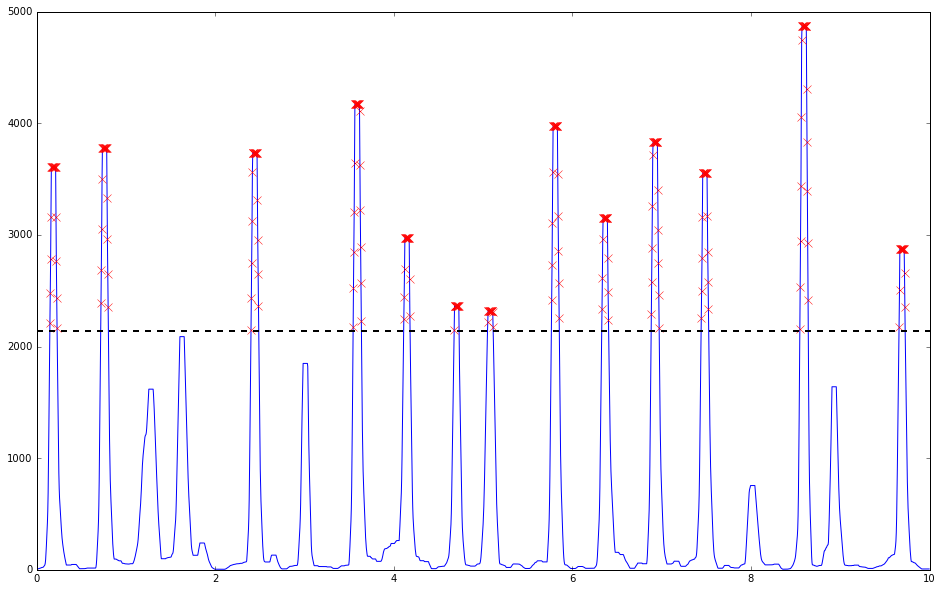

In [20]:
m=1

t_end=10
t=np.asarray(range(sig.shape[0])).astype(float)/fs
idxPeak = np.where(peaks[m][0:fs*t_end])

print t[idxPeak]

plt.figure(figsize=[16,10])
plt.plot(t[0:fs*t_end],sig[0:fs*t_end,m],'b-')
plt.plot(t[idxPeak],np.squeeze(sig[idxPeak,m]),'rx',markersize=8)
plt.plot([0,t_end],[th*thresh,th*thresh],'k--',linewidth=2)
plt.show()